<a href="https://colab.research.google.com/github/tommygarner/tommygarner.github.io/blob/main/technicalfouls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Do technical fouls impact a team's performance?

In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
import re
import requests
import tarfile
import glob
from io import BytesIO
from urllib.request import urlopen
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

## Data Prep/Loading

In [2]:
def load_nba_data(path=".", seasons=range(1996, 2025), data=["datanba", "nbastats", "pbpstats", "cdnnba", "nbastatsv3", "matchups"], seasontype='rg', league='nba', in_memory=False, untar=False):
    """
    Loading a dataset from github

    :param path: Path to save the data.
    :param seasons: Sequence or integer of the year of start of season.
    :param data: Sequence or string of data types to load.
    :param seasontype: Part of season: 'rg' for Regular Season, 'po' for Playoffs.
    :param league: Name league: 'nba' or 'wnba'.
    :param in_memory: Upload data without saving to hard disk.
    :param untar: Do need to untar loaded archive.
    :return: DataFrame if in_memory is True, otherwise None.
    """
    path = os.path.normpath(path)

    if len(data) > 1 and in_memory:
        raise ValueError("Parameter in_memory=True available only when loading a single data type")

    if seasontype == 'rg':
        df_rg = pd.MultiIndex.from_product([data, seasons]).to_frame(index=False)
        need_data = [f"{row[0]}_{row[1]}" for row in df_rg.values]
    elif seasontype == 'po':
        df_po = pd.MultiIndex.from_product([data, ['po'], seasons]).to_frame(index=False)
        need_data = [f"{row[0]}_{row[1]}_{row[2]}" for row in df_po.values]
    else:
        df_rg = pd.MultiIndex.from_product([data, seasons]).to_frame(index=False)
        df_po = pd.MultiIndex.from_product([data, ['po'], seasons]).to_frame(index=False)
        need_data_rg = [f"{row[0]}_{row[1]}" for row in df_rg.values]
        need_data_po = [f"{row[0]}_{row[1]}_{row[2]}" for row in df_po.values]
        need_data = need_data_rg + need_data_po

    if league.lower() == 'wnba':
        need_data = [f"wnba_{d}" for d in need_data]

    # Download list_data.txt
    url = "https://raw.githubusercontent.com/shufinskiy/nba_data/main/list_data.txt"
    try:
        response = requests.get(url)
        response.raise_for_status()
        f = response.text.splitlines()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return

    v = [item.split("=") for item in f]
    name_v = [item[0] for item in v if len(item) == 2]
    element_v = [item[1] for item in v if len(item) == 2]

    need_name = [name for name in name_v if name in need_data]
    need_element = [element_v[i] for i, name in enumerate(name_v) if name in need_data]

    if not os.path.exists(path):
        os.makedirs(path)

    if in_memory:
        df = pd.DataFrame()

    for i in range(len(need_element)):
        if in_memory:
            response = requests.get(need_element[i])
            with tarfile.open(fileobj=BytesIO(response.content), mode="r:xz") as tar:
                csv_file_name = f"{os.path.splitext(os.path.basename(need_element[i]))[0]}.csv"
                member = tar.getmember(csv_file_name)
                tmp_df = pd.read_csv(tar.extractfile(member))
                df = pd.concat([df, tmp_df], ignore_index=True)
        else:
            destfile = os.path.join(path, f"{need_name[i]}.tar.xz")
            with open(destfile, "wb") as f_out:
                response = requests.get(need_element[i])
                f_out.write(response.content)

            if untar:
                with tarfile.open(destfile, "r:xz") as tar:
                    tar.extract(f"{need_name[i]}.csv", path=path)
                os.remove(destfile)

    if in_memory:
        return df

In [3]:
def load_nba_data(path=".", seasons=range(1996, 2025), data=["datanba", "nbastats", "pbpstats", "cdnnba", "nbastatsv3", "matchups"], seasontype='rg', league='nba', in_memory=False, untar=False):
    """
    Loading a dataset from github

    :param path: Path to save the data.
    :param seasons: Sequence or integer of the year of start of season.
    :param data: Sequence or string of data types to load.
    :param seasontype: Part of season: 'rg' for Regular Season, 'po' for Playoffs.
    :param league: Name league: 'nba' or 'wnba'.
    :param in_memory: Upload data without saving to hard disk.
    :param untar: Do need to untar loaded archive.
    :return: DataFrame if in_memory is True, otherwise None.
    """
    path = os.path.normpath(path)

    if len(data) > 1 and in_memory:
        raise ValueError("Parameter in_memory=True available only when loading a single data type")

    if seasontype == 'rg':
        df_rg = pd.MultiIndex.from_product([data, seasons]).to_frame(index=False)
        need_data = [f"{row[0]}_{row[1]}" for row in df_rg.values]
    elif seasontype == 'po':
        df_po = pd.MultiIndex.from_product([data, ['po'], seasons]).to_frame(index=False)
        need_data = [f"{row[0]}_{row[1]}_{row[2]}" for row in df_po.values]
    else:
        df_rg = pd.MultiIndex.from_product([data, seasons]).to_frame(index=False)
        df_po = pd.MultiIndex.from_product([data, ['po'], seasons]).to_frame(index=False)
        need_data_rg = [f"{row[0]}_{row[1]}" for row in df_rg.values]
        need_data_po = [f"{row[0]}_{row[1]}_{row[2]}" for row in df_po.values]
        need_data = need_data_rg + need_data_po

    if league.lower() == 'wnba':
        need_data = [f"wnba_{d}" for d in need_data]

    # Download list_data.txt
    url = "https://raw.githubusercontent.com/shufinskiy/nba_data/main/list_data.txt"
    try:
        response = requests.get(url)
        response.raise_for_status()
        f = response.text.splitlines()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return

    v = [item.split("=") for item in f]
    name_v = [item[0] for item in v if len(item) == 2]
    element_v = [item[1] for item in v if len(item) == 2]

    need_name = [name for name in name_v if name in need_data]
    need_element = [element_v[i] for i, name in enumerate(name_v) if name in need_data]

    if not os.path.exists(path):
        os.makedirs(path)

    if in_memory:
        df = pd.DataFrame()

    for i in range(len(need_element)):
        if in_memory:
            response = requests.get(need_element[i])
            with tarfile.open(fileobj=BytesIO(response.content), mode="r:xz") as tar:
                # Corrected: Extract filename from element_v and remove '.tar.xz'
                csv_file_name = os.path.basename(need_element[i]).replace('.tar.xz', '.csv')
                member = tar.getmember(csv_file_name)
                tmp_df = pd.read_csv(tar.extractfile(member))
                df = pd.concat([df, tmp_df], ignore_index=True)
        else:
            destfile = os.path.join(path, f"{need_name[i]}.tar.xz")
            with open(destfile, "wb") as f_out:
                response = requests.get(need_element[i])
                f_out.write(response.content)

            if untar:
                with tarfile.open(destfile, "r:xz") as tar:
                    tar.extract(f"{need_name[i]}.csv", path=path)
                os.remove(destfile)

    if in_memory:
        return df

In [36]:
# Call function to download and untar the data directly into memory
# Load regular season data
all_pbp_data_rg = load_nba_data(seasons=range(1996, 2024),
                             data=["pbpstats"],
                             seasontype='rg',
                             league='nba',
                             in_memory=True)
all_pbp_data_rg['playoff'] = 0 # Add playoff column, 0 for regular season

# Load playoff data
all_pbp_data_po = load_nba_data(seasons=range(1996, 2024),
                             data=["pbpstats"],
                             seasontype='po',
                             league='nba',
                             in_memory=True)
all_pbp_data_po['playoff'] = 1 # Add playoff column, 1 for playoffs

# Concatenate regular season and playoff data
all_pbp_data = pd.concat([all_pbp_data_rg, all_pbp_data_po], ignore_index=True)


def calculate_countdown_time(df):
    """Calculates the reverse countdown time for each event."""
    df = df[df['PERIOD'] <= 4].copy()
    df['start_minutes'] = df['STARTTIME'].str[:2].astype(float)
    df['start_seconds'] = df['STARTTIME'].str[3:].astype(float)
    df['countdown_time'] = (4 - df['PERIOD']) * (12 * 60) + (12 * 60 - (df['start_minutes'] * 60 + df['start_seconds']))
    return df

# Calculate countdown time and sort the data
all_pbp_data = calculate_countdown_time(all_pbp_data)
all_pbp_data = all_pbp_data.dropna(subset=['countdown_time']).sort_values(by='GAMEID')

display(all_pbp_data.head())

,ENDTIME,EVENTS,FG2A,FG2M,FG3A,FG3M,GAMEDATE,GAMEID,NONSHOOTINGFOULSTHATRESULTEDINFTS,OFFENSIVEREBOUNDS,...,STARTSCOREDIFFERENTIAL,STARTTIME,STARTTYPE,TURNOVERS,DESCRIPTION,URL,playoff,start_minutes,start_seconds,countdown_time
3,00:43,MISS Rice 16' Jump Shot\nKnight REBOUND (Off:1...,1,0,1,1,2000-10-31,20000001,0,1,...,-30,01:01,Off FT Make,0,Knight REBOUND (Off:1 Def:2),NaN,0,1.0,1.0,659.0
2,00:43,MISS Rice 16' Jump Shot\nKnight REBOUND (Off:1...,1,0,1,1,2000-10-31,20000001,0,1,...,-30,01:01,Off FT Make,0,MISS Rice 16' Jump Shot,NaN,0,1.0,1.0,659.0
208,05:15,MacCulloch Layup (2 PTS) (Kukoc 3 AST)\n,1,1,0,0,2000-10-31,20000001,0,0,...,29,05:28,Off At Rim Make,0,MacCulloch Layup (2 PTS) (Kukoc 3 AST),NaN,0,5.0,28.0,392.0
207,04:22,MISS MacCulloch 9' Jump Shot\nKnight REBOUND (...,1,0,0,0,2000-10-31,20000001,0,0,...,29,04:42,Off Short Mid-Range Make,0,Knight REBOUND (Off:0 Def:1),NaN,0,4.0,42.0,438.0
206,04:22,MISS MacCulloch 9' Jump Shot\nKnight REBOUND (...,1,0,0,0,2000-10-31,20000001,0,0,...,29,04:42,Off Short Mid-Range Make,0,MISS MacCulloch 9' Jump Shot,NaN,0,4.0,42.0,438.0


In [37]:
all_pbp_data.shape

(11829154, 23)

In [38]:
all_pbp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11829154 entries, 3 to 11922073
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   ENDTIME                            object 
 1   EVENTS                             object 
 2   FG2A                               int64  
 3   FG2M                               int64  
 4   FG3A                               int64  
 5   FG3M                               int64  
 6   GAMEDATE                           object 
 7   GAMEID                             int64  
 8   NONSHOOTINGFOULSTHATRESULTEDINFTS  int64  
 9   OFFENSIVEREBOUNDS                  int64  
 10  OPPONENT                           object 
 11  PERIOD                             int64  
 12  SHOOTINGFOULSDRAWN                 int64  
 13  STARTSCOREDIFFERENTIAL             int64  
 14  STARTTIME                          object 
 15  STARTTYPE                          object 
 16  TURNOVERS            

In [39]:
all_pbp_data['OPPONENT'].value_counts()

,count
OPPONENT,
BOS,427355
GSW,420336
LAL,418026
MIA,411523
DAL,410772
SAS,410658
PHX,406647
DEN,404626
IND,403862


In [40]:
all_pbp_data['playoff'].value_counts()

,count
playoff,
0,11070243
1,758911


In [123]:
# Filter for only technical fouls
# Exclude 'action_team' from selection as it's not determined accurately at this stage
techs_all = all_pbp_data[all_pbp_data['DESCRIPTION'].str.contains("T.FOUL", na=False)].copy()
techs_all = techs_all[['GAMEDATE', 'GAMEID', 'playoff', 'OPPONENT', 'countdown_time', 'EVENTS', 'DESCRIPTION', 'TURNOVERS', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'OFFENSIVEREBOUNDS']].sort_values(by='GAMEID')

# Differentiate between technical and flagrant fouls
techs_all['foul_type'] = techs_all['DESCRIPTION'].apply(lambda x: 1 if re.search(r'\bT\.FOUL\b', x) else 0)
techs_only = techs_all[techs_all['foul_type'] == 1].copy()

# Descriptive stats on total techs in dataset
techs_descriptive = techs_only.groupby('GAMEID').size().reset_index(name='total_techs')
print(techs_descriptive.describe())

# Games with at least one technical foul between 44 and 4 minutes
techs_in_timeframe = techs_only[(techs_only['countdown_time'] >= 240) & (techs_only['countdown_time'] <= 2640)].copy()
one_tech = techs_in_timeframe.groupby('GAMEID').filter(lambda x: len(x) >= 1).copy()

# Determine action_team based on opponent and the other team in the game
def assign_action_team(row, all_data):
    game_id = row['GAMEID']
    opponent = row['OPPONENT']
    game_data = all_data[all_data['GAMEID'] == game_id]
    teams_in_game = game_data['OPPONENT'].unique()

    if len(teams_in_game) == 2:
        # Assuming opponent is one of the two teams, the other is the action team
        action_team = [team for team in teams_in_game if team != opponent]
        if len(action_team) == 1:
            return action_team[0]
    return None # Return None if action team cannot be determined


one_tech['action_team'] = one_tech.apply(lambda row: assign_action_team(row, all_pbp_data), axis=1)

# Display action_team value counts in the one_tech DataFrame after assigning action_team
print("\nAction team distribution in one_tech (after assigning action_team):")
display(one_tech['action_team'].value_counts())

# Display the first few rows of one_tech to inspect
print("\nFirst few rows of one_tech (after assigning action_team):")
display(one_tech.head())

             GAMEID   total_techs
count  1.245800e+04  12458.000000
mean   2.259163e+07      1.449831
std    5.208870e+06      0.770698
min    2.000000e+07      1.000000
25%    2.060013e+07      1.000000
50%    2.120114e+07      1.000000
75%    2.190128e+07      2.000000
max    4.230031e+07      8.000000

Action team distribution in one_tech (after assigning action_team):


,count
action_team,
LAL,586
HOU,580
BOS,578
DEN,576
SAC,573
PHX,569
DAL,565
IND,562
LAC,561



First few rows of one_tech (after assigning action_team):


,GAMEDATE,GAMEID,playoff,OPPONENT,countdown_time,EVENTS,DESCRIPTION,TURNOVERS,FG2M,FG2A,FG3M,FG3A,OFFENSIVEREBOUNDS,foul_type,action_team
117550,2000-10-31,20000002,0,CLE,2375.0,Murray T.FOUL (P2.T1)\nGill Free Throw Technic...,Murray T.FOUL (P2.T1),1,0,0,0,0,0,1,NJN
291063,2000-10-31,20000006,0,SAC,977.0,Webber T.FOUL (P1.T1)\nMercer Free Throw Techn...,Webber T.FOUL (P1.T1),1,0,0,0,0,0,1,CHI
333906,2000-10-31,20000007,0,MIL,496.0,Cassell T.FOUL (P4.T3)\nNash Free Throw Techni...,Cassell T.FOUL (P4.T3),1,0,0,0,0,0,1,DAL
377046,2000-10-31,20000008,0,MIN,382.0,Garnett T.FOUL (P3.T2)\nMobley Free Throw Tech...,Garnett T.FOUL (P3.T2),0,0,0,0,0,0,1,HOU
721,2000-10-31,20000010,0,UTA,1782.0,Lewis L.B.FOUL (P2.PN)\nLewis T.FOUL (P2.PN)\n...,Lewis T.FOUL (P2.PN),0,0,0,0,0,0,1,LAC


Above dataset has 12458 total techs, including multiple in a single game. We need to isolate cases so we can compare performances in a controlled environment, so going to filter down to technicals that occur 1x per game, and enough play time before and after to understand performance differences.

In [124]:
one_tech.describe()

,GAMEID,playoff,countdown_time,TURNOVERS,FG2M,FG2A,FG3M,FG3A,OFFENSIVEREBOUNDS,foul_type
count,1.548100e+04,15481.000000,15481.000000,15481.000000,15481.000000,15481.000000,15481.000000,15481.000000,15481.000000,15481.0
mean,2.264689e+07,0.074478,1309.213423,0.122085,0.248692,0.569731,0.058976,0.201796,0.233577,1.0
std,5.272945e+06,0.262556,631.117469,0.327395,0.433761,0.682041,0.235586,0.429800,0.539726,0.0
min,2.000000e+07,0.000000,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.060011e+07,0.000000,837.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2.130029e+07,0.000000,1239.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,2.200036e+07,0.000000,1859.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
max,4.230031e+07,1.000000,2640.000000,1.000000,2.000000,7.000000,1.000000,4.000000,7.000000,1.0


In [125]:
# Load and clean the rosters data
# Load the CSV with comma as a separator
rosters = pd.read_csv("https://raw.githubusercontent.com/tommygarner/tommygarner.github.io/main/projects/technicalfouls/rosters.csv", encoding='latin1', sep=',')

# Assuming standard column names after changing to CSV
rosters.columns = [col.replace('.', '_') for col in rosters.columns] # This line is no longer strictly necessary for the relevant columns but keeping it for consistency
# print(rosters.columns) # Display columns to diagnose

# Rename columns to standardized names
rosters = rosters.rename(columns={'Team 1': 'team', 'From': 'year_start', 'To': 'year_end'})

rosters = rosters[(rosters['year_start'] > 1980) & (rosters['year_end'] > 1999)].copy()
rosters['last_name'] = rosters['Player'].apply(lambda x: x.split(" ")[-1])

# Keep only necessary columns after renaming
rosters = rosters[['team', 'Player', 'year_start', 'year_end', 'last_name']].copy()

# Define team name mapping
team_mapping = {
    "NJN": "BKN", "CHH": "CHA", "VAN": "MEM", "NOH": "NOP",
    "NOK": "NOP", # Changed NOK to map to NOP
    "SEA": "OKC"
}

# Apply team name mapping to opponent in one_tech
one_tech['OPPONENT'] = one_tech['OPPONENT'].replace(team_mapping)
# Remove unnecessary mapping of all_pbp_data['action_team'] and all_pbp_data['OPPONENT'] here
# all_pbp_data['action_team'] = all_pbp_data['action_team'].replace(team_mapping)
# all_pbp_data['OPPONENT'] = all_pbp_data['OPPONENT'].replace(team_mapping)


# Extract last name from description
def extract_last_name(description):
    match = re.search(r'([\w\s]+\sT\.FOUL)', description)
    if match:
        name = match.group(1).replace(' T.FOUL', '').strip()
        return name.split()[-1]
    return np.nan

one_tech['last_name'] = one_tech['DESCRIPTION'].apply(extract_last_name)
one_tech['GAMEDATE'] = pd.to_datetime(one_tech['GAMEDATE'])
one_tech['year_game'] = one_tech['GAMEDATE'].dt.year

# Display one_tech and its columns before merge to diagnose
# print("One_tech columns before merge:")
# print(one_tech.columns)
# display(one_tech.head())


# Join with rosters
combined_data = pd.merge(one_tech, rosters, on='last_name', how='left')
print(f"\nTotal technical foul events after initial merge: {len(combined_data)}")


# Count reasons for dropping events
# Reason 1: No roster match (year_start or year_end is NaN)
no_roster_match_count = combined_data[(combined_data['year_start'].isna()) | (combined_data['year_end'].isna())].shape[0]
print(f"Number of events dropped due to no roster match: {no_roster_match_count}")

# Filter for events with roster match to analyze other reasons
combined_data_with_roster = combined_data[(combined_data['year_start'].notna()) & (combined_data['year_end'].notna())].copy()

# Reason 2: Roster match found, but game year outside rostered years
out_of_season_count = combined_data_with_roster[
    (combined_data_with_roster['year_game'] < combined_data_with_roster['year_start']) |
    (combined_data_with_roster['year_game'] > combined_data_with_roster['year_end'])
].shape[0]
print(f"Number of events dropped due to game year outside rostered years: {out_of_season_count}")

# Filter for events within rostered years to analyze the last reason
combined_data_in_season = combined_data_with_roster[
    (combined_data_with_roster['year_game'] >= combined_data_with_roster['year_start']) &
    (combined_data_with_roster['year_game'] <= combined_data_with_roster['year_end'])
].copy()


# Reason 3: Roster match found within correct season, but rostered team does not match action team
team_mismatch_count = combined_data_in_season[combined_data_in_season['team'] != combined_data_in_season['action_team']].shape[0]
print(f"Number of events dropped due to rostered team not matching action team: {team_mismatch_count}")


# Filter for rows that meet all criteria
combined_data_filtered = combined_data_in_season[
    (combined_data_in_season['team'] == combined_data_in_season['action_team'])
].copy()

print(f"Number of events remaining after all filtering: {len(combined_data_filtered)}")


# Now, update the action_team based on the rostered team for the filtered data
combined_data_filtered['action_team'] = combined_data_filtered['team']

# Apply team mapping to the action_team after filtering
combined_data_filtered['action_team'] = combined_data_filtered['action_team'].replace(team_mapping)

# Keep only necessary columns and drop duplicates before date filtering
one_tech = combined_data_filtered.drop(columns=['year_game', 'team', 'Player', 'year_start', 'year_end']).sort_values(by='GAMEID').drop_duplicates(subset=['GAMEID'])

# Print date range of one_tech before rule change date filtering
print("\nDate range of technical fouls after initial filtering (before rule change date filter):")
print(f"Min Game Date: {one_tech['GAMEDATE'].min()}")
print(f"Max Game Date: {one_tech['GAMEDATE'].max()}")
print(f"Number of events remaining after all filtering: {len(one_tech)}")


Total technical foul events after initial merge: 250276
Number of events dropped due to no roster match: 1425
Number of events dropped due to game year outside rostered years: 216039
Number of events dropped due to rostered team not matching action team: 28922
Number of events remaining after all filtering: 3890

Date range of technical fouls after initial filtering (before rule change date filter):
Min Game Date: 2000-11-02 00:00:00
Max Game Date: 2024-05-14 00:00:00
Number of events remaining after all filtering: 3334


In [126]:
one_tech.describe()

,GAMEDATE,GAMEID,playoff,countdown_time,TURNOVERS,FG2M,FG2A,FG3M,FG3A,OFFENSIVEREBOUNDS,foul_type
count,3334,3.334000e+03,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.0
mean,2012-09-01 11:35:48.770245888,2.304096e+07,0.094181,1301.124175,0.130174,0.269646,0.655669,0.064787,0.224055,0.293641,1.0
min,2000-11-02 00:00:00,2.000003e+07,0.000000,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2006-06-05 00:00:00,2.060089e+07,0.000000,817.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2012-12-20 00:00:00,2.130064e+07,0.000000,1224.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
75%,2018-10-20 00:00:00,2.200005e+07,0.000000,1856.750000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
max,2024-05-14 00:00:00,4.230023e+07,1.000000,2640.000000,1.000000,2.000000,4.000000,1.000000,3.000000,4.000000,1.0
std,NaN,5.869080e+06,0.292124,635.735551,0.336545,0.445192,0.734211,0.246187,0.448898,0.597907,0.0


Text(360.0, 249.48, 'Q4')

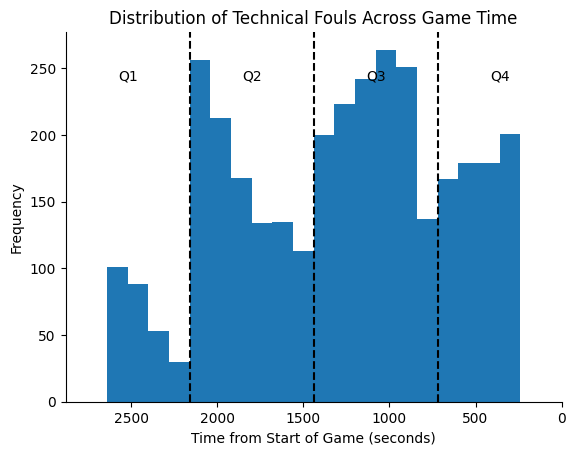

In [127]:
# @title countdown_time

from matplotlib import pyplot as plt
import numpy as np

one_tech['countdown_time'].plot(kind='hist', bins=20, title='Distribution of Technical Fouls Across Game Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Flip the x-axis to show time progressing from the start of the game
plt.xlim(2880, 0)
plt.xlabel("Time from Start of Game (seconds)")
plt.ylabel("Frequency")

# Mark quarter boundaries (countdown_time values)
q1_end_ct = 3 * 12 * 60  # End of 1st quarter
q2_end_ct = 2 * 12 * 60  # End of 2nd quarter
q3_end_ct = 1 * 12 * 60  # End of 3rd quarter

plt.axvline(q1_end_ct, color='black', linestyle='--') # Changed color and removed label
plt.axvline(q2_end_ct, color='black', linestyle='--') # Changed color and removed label
plt.axvline(q3_end_ct, color='black', linestyle='--') # Changed color and removed label

# Add text labels for quarters
plt.text((2880 + q1_end_ct) / 2, plt.gca().get_ylim()[1] * 0.9, 'Q1', ha='center', va='top')
plt.text((q1_end_ct + q2_end_ct) / 2, plt.gca().get_ylim()[1] * 0.9, 'Q2', ha='center', va='top')
plt.text((q2_end_ct + q3_end_ct) / 2, plt.gca().get_ylim()[1] * 0.9, 'Q3', ha='center', va='top')
plt.text(q3_end_ct / 2, plt.gca().get_ylim()[1] * 0.9, 'Q4', ha='center', va='top')

# Removed plt.legend()

In [133]:
# Filter pbp data for games with technical fouls and merge with one_tech to get action_team and countdown_time of the foul
tech_pbp_games = all_pbp_data[all_pbp_data['GAMEID'].isin(one_tech['GAMEID'])].copy()

# Merge tech_pbp_games with one_tech to get the action_team and the specific countdown_time of the technical foul for each game
tech_pbp_split = pd.merge(tech_pbp_games, one_tech[['GAMEID', 'action_team', 'countdown_time']], on='GAMEID', suffixes=('_event', '_foul'))

# Determine "before" or "after" the technical foul based on countdown_time
tech_pbp_split['before_after'] = tech_pbp_split.apply(lambda row: 'before' if row['countdown_time_event'] >= row['countdown_time_foul'] else 'after', axis=1)

# Add FTM and FTA columns by checking the DESCRIPTION
tech_pbp_split['FTA'] = tech_pbp_split['DESCRIPTION'].str.count('Free Throw')
tech_pbp_split['FTM'] = tech_pbp_split['DESCRIPTION'].apply(lambda x: 1 if 'Free Throw' in str(x) and 'MISS' not in str(x) else 0)


# Sum free throws and other stats by event, keeping one row per event to avoid double counting from descriptions
# Group by 'GAMEID', 'before_after', 'action_team', and 'EVENTS' to ensure uniqueness while keeping necessary info
unique_events_tech_games = tech_pbp_split.groupby(['GAMEID', 'before_after', 'action_team', 'EVENTS']).agg(
    FTA=('FTA', 'sum'),
    FTM=('FTM', 'sum'),
    FG2A=('FG2A', 'first'), # Assuming FG2A, FG2M, etc are event-specific and 'first' is representative
    FG2M=('FG2M', 'first'),
    FG3A=('FG3A', 'first'),
    FG3M=('FG3M', 'first'),
    OFFENSIVEREBOUNDS=('OFFENSIVEREBOUNDS', 'first'),
    TURNOVERS=('TURNOVERS', 'first'),
    STARTSCOREDIFFERENTIAL=('STARTSCOREDIFFERENTIAL', 'first'), # Keep score diff at event start
    countdown_time_event=('countdown_time_event', 'first'), # Include event time to calculate duration
    countdown_time_foul=('countdown_time_foul', 'first') # Include foul time
).reset_index()


# Summarize possessions and scoring for each game, team, and period (before/after)
# Group by GAMEID, before_after, and action_team to calculate total stats and duration for each period
tech_pbp_poss = unique_events_tech_games.groupby(['GAMEID', 'before_after', 'action_team']).agg(
    total_FTA=('FTA', 'sum'),
    total_FTM=('FTM', 'sum'),
    total_FG2A=('FG2A', 'sum'),
    total_FG2M=('FG2M', 'sum'),
    total_FG3A=('FG3A', 'sum'),
    total_FG3M=('FG3M', 'sum'),
    total_OREB=('OFFENSIVEREBOUNDS', 'sum'),
    total_TO=('TURNOVERS', 'sum'),
    start_score_diff=('STARTSCOREDIFFERENTIAL', lambda x: x.iloc[0]), # Score diff at the *start* of the period
    first_event_time=('countdown_time_event', 'first'), # Time of the first event in the period
    last_event_time=('countdown_time_event', 'last'), # Time of the last event in the period
    foul_time=('countdown_time_foul', 'first') # Time of the technical foul
).reset_index()

# Calculate duration of the period in seconds
# For 'before' period: Time of foul - Time of first event in period
# For 'after' period: Time of last event in period - Time of foul (approximately)
tech_pbp_poss['duration_seconds'] = tech_pbp_poss.apply(
    lambda row: row['foul_time'] - row['first_event_time'] if row['before_after'] == 'before'
    else row['last_event_time'] - row['foul_time'], axis=1
)


# Calculate possessions using the provided formula
tech_pbp_poss['possessions'] = 0.96 * (
    tech_pbp_poss['total_FG2A'] + tech_pbp_poss['total_FG3A'] +
    tech_pbp_poss['total_TO'] + (0.44 * tech_pbp_poss['total_FTA']) -
    tech_pbp_poss['total_OREB']
)

# Calculate score for the period (score at end of period - score at start of period)
# Need to get the score at the end of the 'before' period and the end of the 'after' period.
# This requires going back to the original tech_pbp_split and finding the score_diff at the *end* of each period.
# Let's simplify and calculate the score difference *change* from the start of the period.

# Re-calculate net rating based on score change and possessions for the period
# Need to find the score at the end of each period. This is not directly available from STARTSCOREDIFFERENTIAL alone.
# The STARTSCOREDIFFERENTIAL is the score difference at the start of an event.
# To get the score change for a period, we need the score difference at the start and end of the period.
# The score difference at the start of the 'before' period is the STARTSCOREDIFFERENTIAL of the first event in the 'before' period.
# The score difference at the end of the 'before' period is the STARTSCOREDIFFERENTIAL of the first event in the 'after' period.
# The score difference at the end of the 'after' period is the STARTSCOREDIFFERENTIAL of the last event in the 'after' period.

# Let's recalculate net rating per game per team per period

def calculate_period_net_rating(group):
    # Access duration directly from the group
    duration_before = group[group['before_after'] == 'before']['duration_seconds'].iloc[0] if 'before' in group['before_after'].values and not group[group['before_after'] == 'before'].empty else np.nan
    duration_after = group[group['before_after'] == 'after']['duration_seconds'].iloc[0] if 'after' in group['before_after'].values and not group[group['before_after'] == 'after'].empty else np.nan

    if 'before' in group['before_after'].values and 'after' in group['before_after'].values:
        before_data = group[group['before_after'] == 'before']
        after_data = group[group['before_after'] == 'after']


        if not before_data.empty and not after_data.empty:
            # Score at start of 'before' period
            score_start_before = before_data['start_score_diff'].iloc[0]
            # Score at end of 'before' period (which is start of 'after' period)
            score_end_before = after_data['start_score_diff'].iloc[0]
            # Score change during 'before' period
            score_change_before = score_end_before - score_start_before

            # Score at start of 'after' period
            score_start_after = after_data['start_score_diff'].iloc[0]
            # Score at end of 'after' period (score diff of the last event in after period)
            # Need to find the last event in the after period and its start_score_diff
            last_event_after_score_diff = tech_pbp_split[
                (tech_pbp_split['GAMEID'] == group['GAMEID'].iloc[0]) &
                (tech_pbp_split['action_team'] == group['action_team'].iloc[0]) & # Ensure we are looking at the correct team's events
                (tech_pbp_split['before_after'] == 'after')
            ]['STARTSCOREDIFFERENTIAL'].iloc[-1] # Get the STARTSCOREDIFFERENTIAL of the last event
            score_end_after = last_event_after_score_diff
            # Score change during 'after' period
            score_change_after = score_end_after - score_start_after


            # Possessions for each period
            possessions_before = before_data['possessions'].sum()
            possessions_after = after_data['possessions'].sum()

            # Net rating per period (score change / possessions * 100)
            net_rating_before = (score_change_before / possessions_before * 100) if possessions_before > 0 else np.nan
            net_rating_after = (score_change_after / possessions_after * 100) if possessions_after > 0 else np.nan


            return pd.Series({
                'net_rating_before': net_rating_before,
                'net_rating_after': net_rating_after,
                'duration_seconds_before': duration_before,
                'duration_seconds_after': duration_after
            })
        else:
             return pd.Series({
                 'net_rating_before': np.nan,
                 'net_rating_after': np.nan,
                 'duration_seconds_before': duration_before, # Include duration even if other data is empty
                 'duration_seconds_after': duration_after
                 })
    else:
        # Handle cases with only before or after data - return duration for the available period
        return pd.Series({
            'net_rating_before': np.nan,
            'net_rating_after': np.nan,
            'duration_seconds_before': duration_before,
            'duration_seconds_after': duration_after
            })


# Apply the net rating calculation function to each game and team
net_rating_summary = tech_pbp_poss.groupby(['GAMEID', 'action_team']).apply(calculate_period_net_rating).reset_index()

# Melt the net rating summary for plotting
net_rating_long = net_rating_summary.melt(
    id_vars=['GAMEID', 'action_team', 'duration_seconds_before', 'duration_seconds_after'], # Include duration columns as id_vars
    value_vars=['net_rating_before', 'net_rating_after'],
    var_name='period',
    value_name='net_rating'
)

# Replace period names for plotting
net_rating_long['period'] = net_rating_long['period'].replace({
    'net_rating_before': 'Before Technical Foul',
    'net_rating_after': 'After Technical Foul'
})

# Display the resulting net rating data including durations
print("Net Rating Summary with Durations:")
display(net_rating_summary.head())

print("\nNet Rating Long format for plotting (includes durations):")
display(net_rating_long.head())

Streaming output truncated to the last 5000 lines.
      dtype='object')
Columns in before_data:
Index(['GAMEID', 'before_after', 'action_team', 'total_FTA', 'total_FTM',
       'total_FG2A', 'total_FG2M', 'total_FG3A', 'total_FG3M', 'total_OREB',
       'total_TO', 'start_score_diff', 'first_event_time', 'last_event_time',
       'foul_time', 'duration_seconds', 'possessions'],
      dtype='object')
Columns in after_data:
Index(['GAMEID', 'before_after', 'action_team', 'total_FTA', 'total_FTM',
       'total_FG2A', 'total_FG2M', 'total_FG3A', 'total_FG3M', 'total_OREB',
       'total_TO', 'start_score_diff', 'first_event_time', 'last_event_time',
       'foul_time', 'duration_seconds', 'possessions'],
      dtype='object')
Columns in group:
Index(['GAMEID', 'before_after', 'action_team', 'total_FTA', 'total_FTM',
       'total_FG2A', 'total_FG2M', 'total_FG3A', 'total_FG3M', 'total_OREB',
       'total_TO', 'start_score_diff', 'first_event_time', 'last_event_time',
       'foul_time',

/tmp/ipython-input-1723831628.py:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_rating_summary = tech_pbp_poss.groupby(['GAMEID', 'action_team']).apply(calculate_period_net_rating).reset_index()


,GAMEID,action_team,net_rating_before,net_rating_after,duration_seconds_before,duration_seconds_after
0,20000026,PHX,29.985976,-4.402649,-299.0,-637.0
1,20000036,ATL,-3.223976,20.446705,-394.0,-792.0
2,20000037,WAS,13.011539,-2.389144,-648.0,-154.0
3,20000042,UTA,7.612049,-1.646123,-1097.0,-763.0
4,20000051,DEN,-1.844311,11.730480,-1976.0,-122.0



Net Rating Long format for plotting (includes durations):


,GAMEID,action_team,duration_seconds_before,duration_seconds_after,period,net_rating
0,20000026,PHX,-299.0,-637.0,Before Technical Foul,29.985976
1,20000036,ATL,-394.0,-792.0,Before Technical Foul,-3.223976
2,20000037,WAS,-648.0,-154.0,Before Technical Foul,13.011539
3,20000042,UTA,-1097.0,-763.0,Before Technical Foul,7.612049
4,20000051,DEN,-1976.0,-122.0,Before Technical Foul,-1.844311


In [134]:
net_rating_long.groupby('GAMEID').describe()

duration_seconds_before                                               \
                           count    mean  std     min     25%     50%     75%   
GAMEID                                                                          
20000026                     2.0  -299.0  0.0  -299.0  -299.0  -299.0  -299.0   
20000036                     2.0  -394.0  0.0  -394.0  -394.0  -394.0  -394.0   
20000037                     2.0  -648.0  0.0  -648.0  -648.0  -648.0  -648.0   
20000042                     2.0 -1097.0  0.0 -1097.0 -1097.0 -1097.0 -1097.0   
20000051                     2.0 -1976.0  0.0 -1976.0 -1976.0 -1976.0 -1976.0   
...                          ...     ...  ...     ...     ...     ...     ...   
42300142                     2.0 -1168.0  0.0 -1168.0 -1168.0 -1168.0 -1168.0   
42300162                     2.0  -640.0  0.0  -640.0  -640.0  -640.0  -640.0   
42300171                     2.0  -245.0  0.0  -245.0  -245.0  -245.0  -245.0   
42300215                     2.0  -420.0  0.0  -420.0  -420.0  -420.0  -420.0   
42300233                     2.0 -1646.0  0.0 -1646.0 -1646.0 -1646.0 -1646.0   

                 duration_seconds_after         ...               net_rating  \
             max                  count   mean  ...    75%    max      count   
GAMEID                                          ...                            
20000026  -299.0                    2.0 -637.0  ... -637.0 -637.0        2.0   
20000036  -394.0                    2.0 -792.0  ... -792.0 -792.0        2.0   
20000037  -648.0                    2.0 -154.0  ... -154.0 -154.0        2.0   
20000042 -1097.0                    2.0 -763.0  ... -763.0 -763.0        2.0   
20000051 -1976.0                    2.0 -122.0  ... -122.0 -122.0        2.0   
...          ...                    ...    ...  ...    ...    ...        ...   
42300142 -1168.0                    2.0  -42.0  ...  -42.0  -42.0        2.0   
42300162  -640.0                    2.0 -484.0  ... -484.0 -484.0        2.0   
42300171  -245.0                    2.0 -270.0  ... -270.0 -270.0        2.0   
42300215  -420.0                    2.0 -941.0  ... -941.0 -941.0        2.0   
42300233 -1646.0                    2.0  -13.0  ...  -13.0  -13.0        2.0   

                                                                    \
                mean         std        min        25%         50%   
GAMEID                                                               
20000026   12.791664   24.316430  -4.402649   4.194507   12.791664   
20000036    8.611364   16.737699  -3.223976   2.693694    8.611364   
20000037    5.311198   10.889927  -2.389144   1.461027    5.311198   
20000042    2.982963    6.546516  -1.646123   0.668420    2.982963   
20000051    4.943085    9.598827  -1.844311   1.549387    4.943085   
...              ...         ...        ...        ...         ...   
42300142   91.919819  157.267875 -19.285362  36.317229   91.919819   
42300162   -4.086556   10.153191 -11.265946  -7.676251   -4.086556   
42300171   76.572604  137.664673 -20.771020  27.900792   76.572604   
42300215   -2.284916   27.218644 -21.531404 -11.908160   -2.284916   
42300233  101.432499  150.940294  -5.298406  48.067046  101.432499   

                                  
                 75%         max  
GAMEID                            
20000026   21.388820   29.985976  
20000036   14.529035   20.446705  
20000037    9.161369   13.011539  
20000042    5.297506    7.612049  
20000051    8.336783   11.730480  
...              ...         ...  
42300142  147.522410  203.125000  
42300162   -0.496861    3.092835  
42300171  125.244415  173.916227  
42300215    7.338328   16.961572  
42300233  154.797951  208.163404  

[3334 rows x 24 columns]

In [80]:
# Filter for rows where GAMEID is 20000026
filtered_net_rating = net_rating_long[net_rating_long['GAMEID'] == 20000026]

# Display the filtered data
display(filtered_net_rating)

,GAMEID,action_team,period,net_rating
0,20000026,PHX,Before Technical Foul,29.985976
3334,20000026,PHX,After Technical Foul,-4.402649


/tmp/ipython-input-2530576130.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='period', y='net_rating', data=net_rating_long, palette=['lightblue', 'lightcoral'])


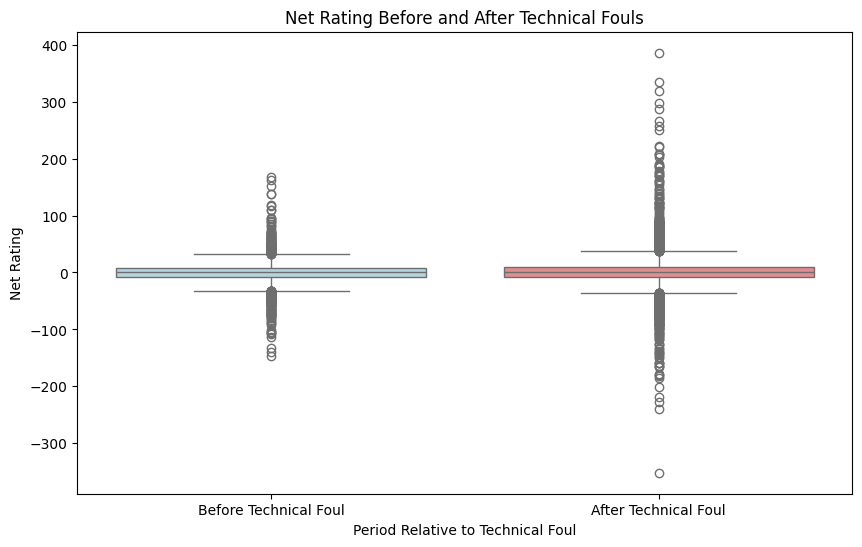

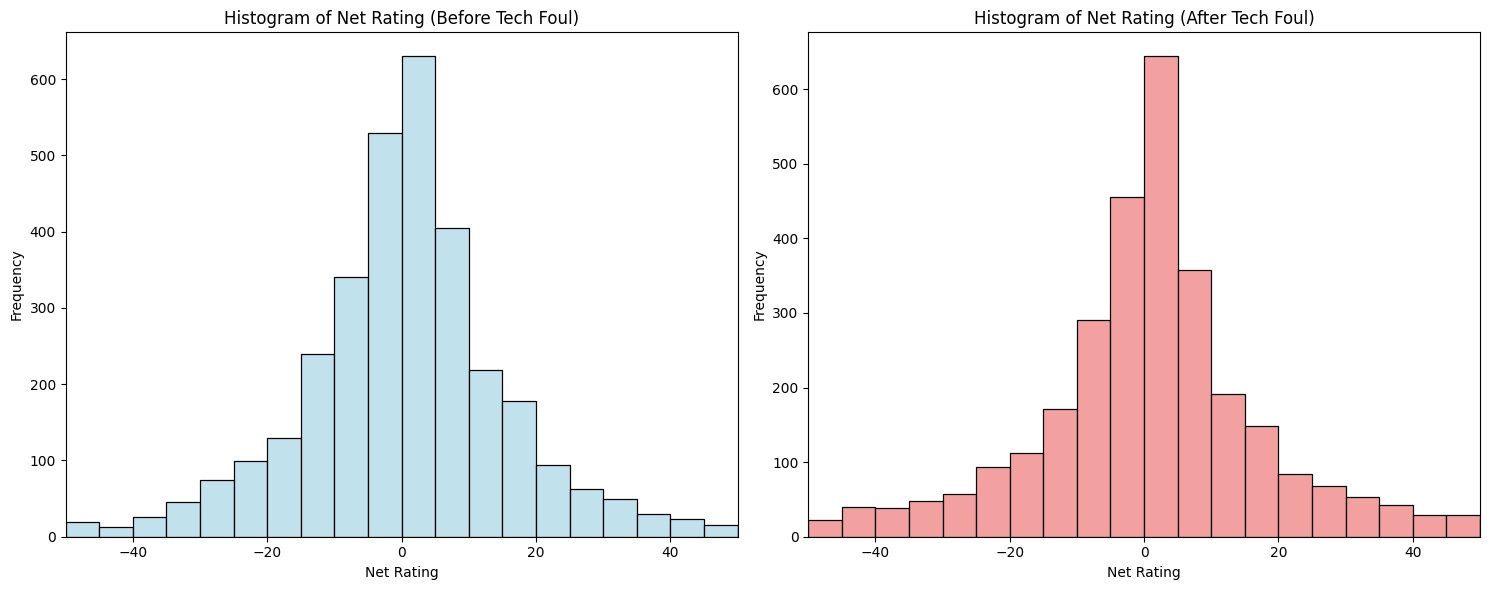

In [130]:
# Join net rating data with one_tech data (although one_tech is not directly used in the plotting code here)
# The net_rating_summary DataFrame already contains the calculated net ratings per game per team per period.
# No need to merge with one_tech for the plotting itself.

# The net_rating_summary DataFrame is already in a suitable format for melting for plotting.
# It has columns: 'GAMEID', 'action_team', 'net_rating_before', 'net_rating_after'.

# Reshape data for overall boxplot
net_rating_long = net_rating_summary.melt(
    id_vars=['GAMEID', 'action_team'],
    value_vars=['net_rating_before', 'net_rating_after'],
    var_name='period',
    value_name='net_rating'
)

# Replace period names for plotting
net_rating_long['period'] = net_rating_long['period'].replace({
    'net_rating_before': 'Before Technical Foul',
    'net_rating_after': 'After Technical Foul'
})

# Overall boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='net_rating', data=net_rating_long, palette=['lightblue', 'lightcoral'])
plt.title("Net Rating Before and After Technical Fouls")
plt.xlabel("Period Relative to Technical Foul")
plt.ylabel("Net Rating")
plt.show()

# Histograms of net rating
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(net_rating_long[net_rating_long['period'] == 'Before Technical Foul']['net_rating'].dropna(), bins=np.arange(-100, 100, 5), color='lightblue', edgecolor='black', ax=ax1)
ax1.set_title("Histogram of Net Rating (Before Tech Foul)")
ax1.set_xlabel("Net Rating")
ax1.set_ylabel("Frequency")
ax1.set_xlim(-50, 50) # Set reasonable limits based on expected net rating range

sns.histplot(net_rating_long[net_rating_long['period'] == 'After Technical Foul']['net_rating'].dropna(), bins=np.arange(-100, 100, 5), color='lightcoral', edgecolor='black', ax=ax2)
ax2.set_title("Histogram of Net Rating (After Tech Foul)")
ax2.set_xlabel("Net Rating")
ax2.set_ylabel("Frequency")
ax2.set_xlim(-50, 50) # Set reasonable limits
plt.tight_layout()
plt.show()

In [96]:
from scipy import stats

# Drop rows with NaN in either net_rating_before or net_rating_after
# The paired t-test requires that the samples are paired, so we need to drop pairs with missing values
net_rating_paired = net_rating_summary.dropna(subset=['net_rating_before', 'net_rating_after'])

# Perform paired t-test
ttest_result = stats.ttest_rel(net_rating_paired['net_rating_before'], net_rating_paired['net_rating_after'])

# Display the results
print("Paired t-test results:")
print(f"  T-statistic: {ttest_result.statistic}")
print(f"  P-value: {ttest_result.pvalue}")

# Interpret the results
alpha = 0.05 # Significance level
if ttest_result.pvalue < alpha:
    print("\nThe difference in net rating before and after a technical foul is statistically significant.")
else:
    print("\nThe difference in net rating before and after a technical foul is not statistically significant.")

Paired t-test results:
  T-statistic: -1.9003857640000585
  P-value: 0.05746872017894005

The difference in net rating before and after a technical foul is not statistically significant.


Beginning with the 2001–02 season, the rule, now known as "Defensive Three Seconds," prohibits a defender from being in the shooting lane for three seconds, unless guarding an opponent within arm's reach (or the player with the ball, regardless of distance). The penalty is the same as it was for an illegal defense, except that no warning is issued. The WNBA implemented this rule in 2013. Any technical fouls for Illegal Defense do not count towards ejection.



In [114]:
# Check for technical fouls related to Defensive Three Seconds or Illegal Defense
defensive_3_seconds_techs = post_rule_change_one_tech[
    post_rule_change_one_tech['DESCRIPTION'].str.contains('Defensive Three Seconds|illegal defense', case=False, na=False)
].copy()

# Display the filtered technical fouls
print("Technical fouls related to Defensive Three Seconds or Illegal Defense:")
display(defensive_3_seconds_techs)

if defensive_3_seconds_techs.empty:
    print("\nNo technical fouls related to Defensive Three Seconds or Illegal Defense found in the filtered data.")
else:
    print(f"\nFound {len(defensive_3_seconds_techs)} technical fouls related to Defensive Three Seconds or Illegal Defense.")

Technical fouls related to Defensive Three Seconds or Illegal Defense:


,GAMEDATE,GAMEID,playoff,OPPONENT,countdown_time,EVENTS,DESCRIPTION,TURNOVERS,FG2M,FG2A,FG3M,FG3A,OFFENSIVEREBOUNDS,foul_type,action_team,last_name



No technical fouls related to Defensive Three Seconds or Illegal Defense found in the filtered data.


In [116]:
#copy one_tech df to post_rule_change_one_tech
post_rule_change_one_tech = one_tech.copy()

#GAMEDATE >= '2001-10-29'
post_rule_change_one_tech = post_rule_change_one_tech[post_rule_change_one_tech['GAMEDATE'] >= '2001-10-29']

len(post_rule_change_one_tech)

3354

Number of unique games before rule change date: 0
Number of unique games on or after rule change date: 3180


Beginning with the 2010–11 season, the NBA began to crack down on general complaining. Technical fouls can now be issued for the following:

*   Making aggressive gestures anywhere on the court
*   Disagreement in which a player demonstrates how he was fouled
*   Running toward an official to complain about a call
Excessive inquiries about a call


### Analysis of Technical Fouls Before Rule Change (Before 2001-10-01)

In [92]:
# Perform net rating calculation for data before rule change
tech_pbp_games_before = all_pbp_data[all_pbp_data['GAMEID'].isin(one_tech_before_rule_change['GAMEID'])].copy()

# Merge tech_pbp_games_before with one_tech_before_rule_change to get action_team and countdown_time of the foul
tech_pbp_split_before = pd.merge(tech_pbp_games_before, one_tech_before_rule_change[['GAMEID', 'action_team', 'countdown_time']], on='GAMEID', suffixes=('_event', '_foul'))

# Determine "before" or "after" the technical foul based on countdown_time
tech_pbp_split_before['before_after'] = tech_pbp_split_before.apply(lambda row: 'before' if row['countdown_time_event'] >= row['countdown_time_foul'] else 'after', axis=1)

# Add FTM and FTA columns by checking the DESCRIPTION
tech_pbp_split_before['FTA'] = tech_pbp_split_before['DESCRIPTION'].str.count('Free Throw')
tech_pbp_split_before['FTM'] = tech_pbp_split_before['DESCRIPTION'].apply(lambda x: 1 if 'Free Throw' in str(x) and 'MISS' not in str(x) else 0)


# Sum free throws and other stats by event, keeping one row per event to avoid double counting from descriptions
unique_events_tech_games_before = tech_pbp_split_before.groupby(['GAMEID', 'before_after', 'action_team', 'EVENTS']).agg(
    FTA=('FTA', 'sum'),
    FTM=('FTM', 'sum'),
    FG2A=('FG2A', 'first'),
    FG2M=('FG2M', 'first'),
    FG3A=('FG3A', 'first'),
    FG3M=('FG3M', 'first'),
    OFFENSIVEREBOUNDS=('OFFENSIVEREBOUNDS', 'first'),
    TURNOVERS=('TURNOVERS', 'first'),
    STARTSCOREDIFFERENTIAL=('STARTSCOREDIFFERENTIAL', 'first')
).reset_index()

# Summarize possessions and scoring for each game, team, and period (before/after)
tech_pbp_poss_before = unique_events_tech_games_before.groupby(['GAMEID', 'before_after', 'action_team']).agg(
    total_FTA=('FTA', 'sum'),
    total_FTM=('FTM', 'sum'),
    total_FG2A=('FG2A', 'sum'),
    total_FG2M=('FG2M', 'sum'),
    total_FG3A=('FG3A', 'sum'),
    total_FG3M=('FG3M', 'sum'),
    total_OREB=('OFFENSIVEREBOUNDS', 'sum'),
    total_TO=('TURNOVERS', 'sum'),
    start_score_diff=('STARTSCOREDIFFERENTIAL', lambda x: x.iloc[0])
).reset_index()

# Calculate possessions
tech_pbp_poss_before['possessions'] = 0.96 * (
    tech_pbp_poss_before['total_FG2A'] + tech_pbp_poss_before['total_FG3A'] +
    tech_pbp_poss_before['total_TO'] + (0.44 * tech_pbp_poss_before['total_FTA']) -
    tech_pbp_poss_before['total_OREB']
)

# Calculate period net rating
def calculate_period_net_rating_before(group):
    if 'before' in group['before_after'].values and 'after' in group['before_after'].values:
        before_data = group[group['before_after'] == 'before']
        after_data = group[group['before_after'] == 'after']

        if not before_data.empty and not after_data.empty:
            score_start_before = before_data['start_score_diff'].iloc[0]
            score_end_before = after_data['start_score_diff'].iloc[0]
            score_change_before = score_end_before - score_start_before

            score_start_after = after_data['start_score_diff'].iloc[0]
            # Need to find the last event in the after period and its start_score_diff from the original tech_pbp_split_before
            last_event_after_score_diff = tech_pbp_split_before[
                (tech_pbp_split_before['GAMEID'] == group['GAMEID'].iloc[0]) &
                (tech_pbp_split_before['action_team'] == group['action_team'].iloc[0]) &
                (tech_pbp_split_before['before_after'] == 'after')
            ]['STARTSCOREDIFFERENTIAL'].iloc[-1]
            score_end_after = last_event_after_score_diff
            score_change_after = score_end_after - score_start_after

            possessions_before = before_data['possessions'].sum()
            possessions_after = after_data['possessions'].sum()

            net_rating_before = (score_change_before / possessions_before * 100) if possessions_before > 0 else np.nan
            net_rating_after = (score_change_after / possessions_after * 100) if possessions_after > 0 else np.nan

            return pd.Series({
                'net_rating_before': net_rating_before,
                'net_rating_after': net_rating_after
            })
        else:
             return pd.Series({'net_rating_before': np.nan, 'net_rating_after': np.nan})
    else:
        return pd.Series({'net_rating_before': np.nan, 'net_rating_after': np.nan})


net_rating_summary_before = tech_pbp_poss_before.groupby(['GAMEID', 'action_team']).apply(calculate_period_net_rating_before).reset_index()

display(net_rating_summary_before.head())

/tmp/ipython-input-1776536674.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_rating_summary_before = tech_pbp_poss_before.groupby(['GAMEID', 'action_team']).apply(calculate_period_net_rating_before).reset_index()


ValueError: cannot insert action_team, already exists

### Paired t-test for Technical Fouls Before Rule Change

In [93]:
from scipy import stats

# Drop rows with NaN in either net_rating_before or net_rating_after
net_rating_paired_before = net_rating_summary_before.dropna(subset=['net_rating_before', 'net_rating_after'])

# Perform paired t-test
ttest_result_before = stats.ttest_rel(net_rating_paired_before['net_rating_before'], net_rating_paired_before['net_rating_after'])

# Display the results
print("Paired t-test results (Before Rule Change):")
print(f"  T-statistic: {ttest_result_before.statistic}")
print(f"  P-value: {ttest_result_before.pvalue}")

# Interpret the results
alpha = 0.05 # Significance level
if ttest_result_before.pvalue < alpha:
    print("\nThe difference in net rating before and after a technical foul (Before Rule Change) is statistically significant.")
else:
    print("\nThe difference in net rating before and after a technical foul (Before Rule Change) is not statistically significant.")

NameError: name 'net_rating_summary_before' is not defined